# EOF analysis of AVISO absolute dynamic topography (`ADT`) in the North Atlantic

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy import stats
from scipy.linalg import svd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def detrend(y):
    x = np.arange(0,len(y))
    not_nan_ind = ~np.isnan(y)
    if len(x[not_nan_ind]) < 2:
        return np.nan * y
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    return  y - (m*x + b)

### Read data files

In [3]:
# Sea surface height anomaly
ds = xr.open_dataset('/home/jet/data/cmems/aviso/converted/dt_global_allsat_phy_l4/dt_global_allsat_phy_l4_monthly_regridded_day15.nc')

In [4]:
print str(ds.time.values[0])[:10]
print str(ds.time.values[-1])[:10]

1993-01-15
2016-12-15


### Set temporal and spatial ranges

In [5]:
tstart = '1993-01-15'
tend = '2016-12-15'

south = 20
north = 70
west = -80
east = 0

### Subsample dataset to array

In [6]:
arr = ds.adt.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

In [7]:
print str(arr.time.values[0])[:10]
print str(arr.time.values[-1])[:10]

1993-01-15
2016-12-15


In [8]:
n = len(arr.time)

### Calculate anomlies
The following removes the temporal mean for a given pixel location from the time series for that same location to produce a time series of anomalies

In [9]:
arr = arr-arr.mean('time')
arr = arr.groupby('time.month') - arr.groupby('time.month').mean('time')

### Detrend

In [10]:
arr = xr.DataArray(np.apply_along_axis(detrend, 0, arr.transpose('time','lat','lon')),
                   coords=[arr.time,arr.lat,arr.lon],dims=['time','lat','lon'])

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


### Good locations
Find pixel locations where all the data is present for each time point. Ff even one time point at a given location is missing, that location will be excluded from the eof analysis

In [11]:
# 2D Array formed after sum
flattend_array = np.sum(np.isfinite(arr.values),axis=0)

# Locations in a 2D that have all good data for all nfiles
good_locations = np.where(flattend_array  == n)

### Create EOF matrix

In [12]:
eof_matrix= np.zeros((n,len(good_locations[0])), dtype=float)

for i in range(n): 
    result = arr.values[i,good_locations[0],good_locations[1]]    
    eof_matrix[i,:] = result

### Normalize each time series
Normalize the time series at each location by dividing by the standard deviation of the data at the respective location.

In [13]:
stdv_geophys = np.asarray(map(np.sqrt, np.sum(eof_matrix**2.0,axis=0)))/(n-1)

for i in range(n):
    eof_matrix[i,:] = eof_matrix[i,:]/stdv_geophys

### Singular Value Decomposition
Note: Transpose is taken becaue svd function expects a matrix that has vectors that are trasnposed relative to how the data were orginally read into the eof_martix.

In [14]:
eof_matrix = np.transpose(eof_matrix)

U, S, V = svd(eof_matrix,full_matrices=False)

### Calculate variances

In [15]:
variances = 100.0*S**2/np.sum(S**2)

### Singular values

In [16]:
s_matrix= np.zeros((n, n))

for i in range(n):
    s_matrix[i,i]=S[i]

### PC timeseries

In [17]:
svdc_time_series = np.dot(s_matrix,V)

### Sort index
Sort eof/svd index order so that each eof mode variance explained goes from mode with the highest amount of orginal variance explained to mode with least amount of variance explained. This gives output with mode 1 having the highest explained variance.

In [18]:
sorted_var_index = np.argsort(-variances)

Note: Typically you would not try to inerpret more the first 3 eof modes.

In [19]:
print '1993-2016:'
print 1, ':  ', variances[sorted_var_index[0]]
print 2, ':  ', variances[sorted_var_index[1]]
print 3, ':  ', variances[sorted_var_index[2]]

1993-2016:
1 :   11.88607734318545
2 :   7.218646836741718
3 :   3.566762057998364


### Set dimensions

In [20]:
xdim=np.shape(arr)[2]
ydim=np.shape(arr)[1]

### Spatial Eigenfunction

In [21]:
arr_img = np.zeros((ydim,xdim)) + np.nan

## Plots

### Mode 1

In [22]:
arr_img[good_locations[0],good_locations[1]] = U[:,sorted_var_index[0]]

In [23]:
# Use +/- (1.0) to change the color coding of weights
pc_normalize_factor = np.nanmax(abs(arr_img))*(-1.0)
eof01 = arr_img/pc_normalize_factor

In [24]:
ds_eof = xr.Dataset({'eof01': (['lat', 'lon'], eof01*-1)},coords={'lon': arr.lon.values,'lat': arr.lat.values})

/opt/rh/python27/root/usr/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


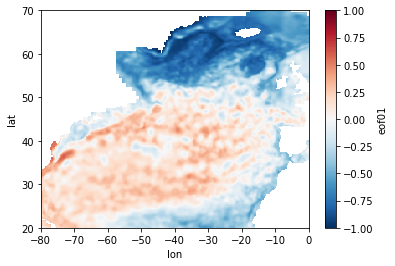

In [25]:
ds_eof.eof01.plot()

In [26]:
ds_eof.to_netcdf('aviso_eof01_detrend.nc', format='NETCDF4',
                 encoding={'eof01': {'dtype': 'float32', 'zlib': True}})

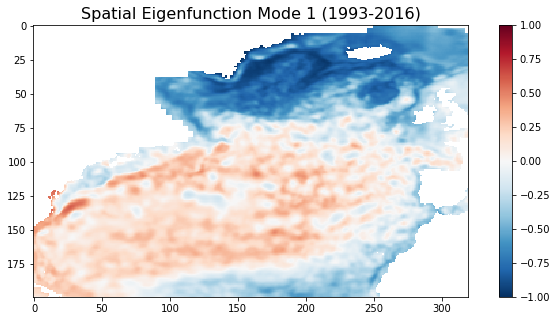

In [26]:
plt.figure(figsize=(11,5))

plt.title('Spatial Eigenfunction Mode 1 (1993-2016)',fontsize=16)
plt.imshow(np.flipud(eof01*-1), cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.colorbar(orientation='vertical')

#plt.savefig('/tmp/figure.png')
plt.show()

In [27]:
svdc_time_series[sorted_var_index[0],:] = svdc_time_series[sorted_var_index[0],:]*pc_normalize_factor

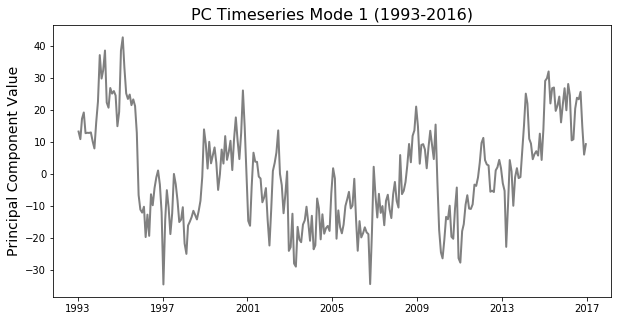

In [28]:
plt.figure(figsize=(10,5))

plt.plot(arr.time,svdc_time_series[sorted_var_index[0],:]*-1, lw=2, color='grey')

#plt.xlim(['2003-08-31','2016-05-01'])
#plt.ylim([-30,20])
#plt.xticks(pd.date_range('2004-01-01','2017-01-01',freq='12M'),fontsize=12)
#plt.yticks(np.arange(-30,30,10),fontsize=12)
plt.ylabel('Principal Component Value',fontsize=14)
plt.title('PC Timeseries Mode 1 (1993-2016)',fontsize=16)

#plt.savefig('/tmp/figure.png')
plt.show()

### Time series

In [29]:
df = pd.DataFrame(data={'SPGI_detrend': svdc_time_series[sorted_var_index[0],:]*-1},index=arr.time)

In [30]:
df.head()

,SPGI_detrend
time,
1993-01-15 00:00:00.000000000,13.241923
1993-02-15 00:00:00.124715008,10.856430
1993-03-15 00:00:00.046858240,17.225033
1993-04-15 00:00:00.171573248,19.205997
1993-05-15 00:00:00.586678272,12.723967


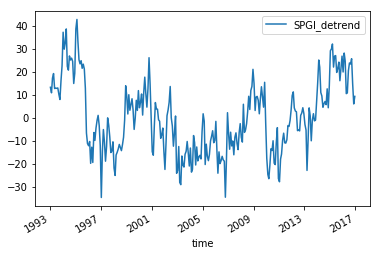

In [31]:
df.plot()

In [32]:
df.to_csv('SPGI_detrend.csv', index=True)